# Clustering Sports Venues in Navi Mumbai

#### Vijayandra Mahadik

## Introduction

The aim of the project is to explore different variety of options to play different sports within Navi Mumbai and then group places based on similar sport options they provide. We will use Foursquare API to find different sport venues for each place and then group these places together using K-means clustering algorithm. 

### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import warnings
warnings.filterwarnings('ignore')

print('Libraries imported.')

Libraries imported.


### Create Dataset

#### Use geopy library to get the latitude and longitude values of Navi Mumbai.

In [2]:
address = 'Navi Mumbai'

geolocator = Nominatim(user_agent="nm_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Navi Mumbai are 19.0308262, 73.0198537.


Create a list of Stations in Navi Mumbai

List of station names taken from https://en.wikipedia.org/wiki/Trans-Harbour_line_(Mumbai_Suburban_Railway) link

**NOTE**: There are mulitple places with name Mansarovar hence to get Navi Mumbai specific location 'Mansarovar, Navi Mumbai' keyword is used

In [3]:
NaviMumbai_Stations = [
'Airoli',
'Rabale',
'Ghansoli',
'Kopar Khairane',
'Turbhe',
'Sanpada',
'Vashi',
'Juinagar',
'Nerul',
'Seawoods-Darave',
'CBD Belapur',
'Kharghar',
'Mansarovar, Navi Mumbai',
'Khandeshwar'
]

#### Get Latitude and Longitude of each station and create pandas dataframe

In [4]:
geolocator = Nominatim(user_agent="nm_explorer")
column_name = ['Neighborhood','Latitude','Longitude']
neighborhoods = pd.DataFrame(columns = column_name)
for address in NaviMumbai_Stations:
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    neighborhoods = neighborhoods.append({'Neighborhood': address,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)

neighborhoods['Neighborhood'].replace('Mansarovar, Navi Mumbai','Mansarovar', inplace=True)
neighborhoods

,Neighborhood,Latitude,Longitude
0,Airoli,19.158272,72.996709
1,Rabale,19.136637,73.002781
2,Ghansoli,19.119331,72.999510
3,Kopar Khairane,19.102852,73.003075
4,Turbhe,19.076165,73.017662
5,Sanpada,19.065977,73.009533
6,Vashi,19.075713,73.000354
7,Juinagar,19.056169,73.018245
8,Nerul,19.033612,73.018140
9,Seawoods-Darave,19.022192,73.018738


#### Create a map of Navi Mumbai with neighborhoods superimposed on top.

In [5]:
# create map of Navi Mumbai using latitude and longitude values
map_navimumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_navimumbai)  
    
map_navimumbai

Utilize the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [41]:
CLIENT_ID = 'XXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 250

#### Create a function to use Foursquare API and get nearby 250 venues for each station with a radius of 1.5 Km

We will search **Athletics & Sports** venues using ID: 4f4528bc4b90abdf24c9de85

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4f4528bc4b90abdf24c9de85&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Call above function on each neighborhood and create a new dataframe called *navimumbai_venues*.

In [8]:
navimumbai_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius=1500
                                  )

Airoli
Rabale
Ghansoli
Kopar Khairane
Turbhe
Sanpada
Vashi
Juinagar
Nerul
Seawoods-Darave
CBD Belapur
Kharghar
Mansarovar
Khandeshwar


#### Let's check if any station has no sports venue and remove such stations

In [9]:
novenues = list(set(neighborhoods['Neighborhood'].unique()) - set(navimumbai_venues['Neighborhood'].unique()))
novenues

['Khandeshwar']

Removing stations with no sport venue

In [10]:
neighborhoods = neighborhoods[~neighborhoods['Neighborhood'].isin(novenues)]
neighborhoods

,Neighborhood,Latitude,Longitude
0,Airoli,19.158272,72.996709
1,Rabale,19.136637,73.002781
2,Ghansoli,19.119331,72.999510
3,Kopar Khairane,19.102852,73.003075
4,Turbhe,19.076165,73.017662
5,Sanpada,19.065977,73.009533
6,Vashi,19.075713,73.000354
7,Juinagar,19.056169,73.018245
8,Nerul,19.033612,73.018140
9,Seawoods-Darave,19.022192,73.018738


As the stations are close to each other, there is a chance that a same venue gets picked for two different stations creating duplicates. Let's check and remove duplicates if any.

In [11]:
def check_duplicate(df,cols):
    df_dups = df[df.duplicated(cols, keep=False)].sort_values(by=cols, ascending=False)
    df_dups_removed = df[df.duplicated(cols, keep='last')].sort_values(by=cols, ascending=False)
    
    df_distinct = df[df.groupby(cols)['Neighborhood'].transform('count') == 1]
    nmum_venues = pd.concat([df_distinct, df_dups_removed], axis=0)
    return df_dups, df_dups_removed, nmum_venues

In [12]:
venue_cols = ['Venue Latitude','Venue Longitude','Venue Category']
df_dups, df_dups_removed, nmum_venues = check_duplicate(navimumbai_venues,venue_cols)

There are some venues which are picked for two adjacent stations

In [13]:
print ("Duplicate Venues:", int(df_dups.shape[0]/2))

Duplicate Venues: 89


Talwarkar gym is picked for both Airoli and Rabale station. Let's drop one.

In [14]:
df_dups.head(4)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
6,Airoli,19.158272,72.996709,Talwarkar gym,19.151183,72.999631,Gym / Fitness Center
18,Rabale,19.136637,73.002781,Talwarkar gym,19.151183,72.999631,Gym / Fitness Center
13,Airoli,19.158272,72.996709,Health and Fitness Point,19.150337,72.994701,Gym
25,Rabale,19.136637,73.002781,Health and Fitness Point,19.150337,72.994701,Gym


In [15]:
df_dups_removed.head(4)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
6,Airoli,19.158272,72.996709,Talwarkar gym,19.151183,72.999631,Gym / Fitness Center
13,Airoli,19.158272,72.996709,Health and Fitness Point,19.150337,72.994701,Gym
8,Airoli,19.158272,72.996709,Machineless Workout,19.147927,72.995162,Sports Club
10,Airoli,19.158272,72.996709,Fitness City Gym,19.147374,72.999631,Gym / Fitness Center


In [16]:
print ("Duplicate Venues removed:", navimumbai_venues.shape[0] - nmum_venues.shape[0])

Duplicate Venues removed: 76


There are many Gym venues with different names. Let's group them into single venue .

In [17]:
gym = list(nmum_venues[nmum_venues['Venue Category'].str.contains('Gym')]['Venue Category'].unique())
gym

['Gym', 'Gym / Fitness Center', 'Gym Pool', 'Boxing Gym']

In [18]:
nmum_venues['Venue Category'].replace(to_replace=gym, value='Gym', inplace=True)

In [19]:
nmum_venues[nmum_venues.Neighborhood == 'Vashi'].head(6)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
91,Vashi,19.075713,73.000354,Sector 9 Ground,19.080126,72.993422,Garden
92,Vashi,19.075713,73.000354,NMSA Gymnasium,19.072205,72.992036,Gym
93,Vashi,19.075713,73.000354,"Talwalkars Fitness Centre, Vashi",19.073968,72.991247,Gym
95,Vashi,19.075713,73.000354,father agnel Football Ground,19.077786,72.993859,Soccer Field
97,Vashi,19.075713,73.000354,Fr. Agnels Basket Ball Court,19.074515,72.988070,Basketball Court
101,Vashi,19.075713,73.000354,football ground,19.078545,72.994452,Soccer Field


Let's check how many venues were returned for each neighborhood

In [20]:
nmum_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Airoli,15,15,15,15,15,15
CBD Belapur,8,8,8,8,8,8
Ghansoli,8,8,8,8,8,8
Juinagar,4,4,4,4,4,4
Kharghar,9,9,9,9,9,9
Kopar Khairane,6,6,6,6,6,6
Mansarovar,4,4,4,4,4,4
Nerul,23,23,23,23,23,23
Rabale,3,3,3,3,3,3


#### Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(nmum_venues['Venue Category'].unique())))

There are 16 uniques categories.


## Analyze Each Neighborhood

In [22]:
# one hot encoding
nmum_onehot = pd.get_dummies(nmum_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nmum_onehot['Neighborhood'] = nmum_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nmum_onehot.columns[-1]] + list(nmum_onehot.columns[:-1])
nmum_onehot = nmum_onehot[fixed_columns]

nmum_onehot.head()

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Garden,Golf Course,Gym,Hotel,Martial Arts Dojo,Residential Building (Apartment / Condo),Soccer Field,Sporting Goods Shop,Sports Club,Tennis Court,Track,Volleyball Court,Yoga Studio
0,Airoli,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Airoli,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Airoli,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Airoli,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Airoli,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


And let's examine the new dataframe size.

In [23]:
nmum_onehot.shape

(154, 17)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
nmum_grouped = nmum_onehot.groupby('Neighborhood').mean().reset_index()
nmum_grouped

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Garden,Golf Course,Gym,Hotel,Martial Arts Dojo,Residential Building (Apartment / Condo),Soccer Field,Sporting Goods Shop,Sports Club,Tennis Court,Track,Volleyball Court,Yoga Studio
0,Airoli,0.133333,0.000000,0.000000,0.00,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000,0.200000,0.000000,0.000000,0.00,0.00
1,CBD Belapur,0.250000,0.000000,0.000000,0.00,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.00,0.00
2,Ghansoli,0.000000,0.000000,0.000000,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.00
3,Juinagar,0.250000,0.000000,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.250000,0.000,0.000000,0.000000,0.000000,0.00,0.00
4,Kharghar,0.111111,0.000000,0.000000,0.00,0.000000,0.777778,0.000000,0.000000,0.000000,0.111111,0.000,0.000000,0.000000,0.000000,0.00,0.00
5,Kopar Khairane,0.000000,0.000000,0.000000,0.00,0.000000,0.833333,0.000000,0.166667,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.00
6,Mansarovar,0.000000,0.000000,0.250000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.25,0.00
7,Nerul,0.173913,0.000000,0.000000,0.00,0.000000,0.695652,0.000000,0.000000,0.000000,0.000000,0.000,0.086957,0.000000,0.043478,0.00,0.00
8,Rabale,0.000000,0.000000,0.333333,0.00,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.00
9,Sanpada,0.173913,0.043478,0.043478,0.00,0.043478,0.521739,0.043478,0.000000,0.043478,0.086957,0.000,0.000000,0.000000,0.000000,0.00,0.00


#### Let's confirm the new size

In [25]:
nmum_grouped.shape

(13, 17)

#### Let's print each neighborhood along with the top 5 most common venues

<Figure size 720x504 with 0 Axes>

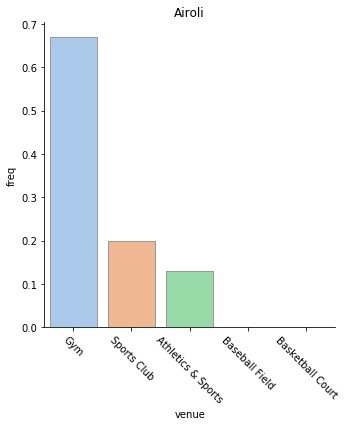

<Figure size 720x504 with 0 Axes>

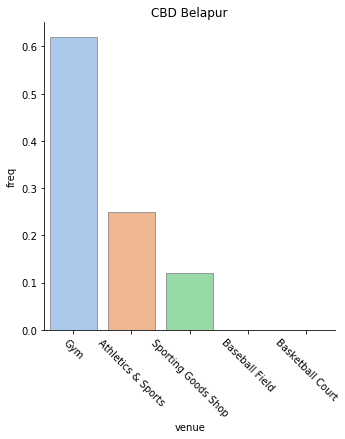

<Figure size 720x504 with 0 Axes>

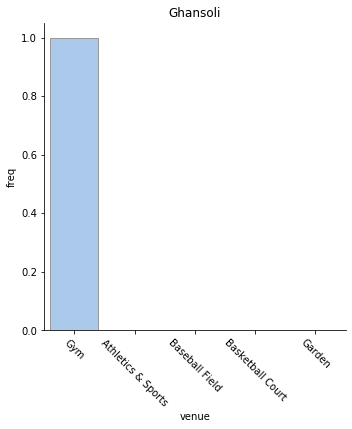

<Figure size 720x504 with 0 Axes>

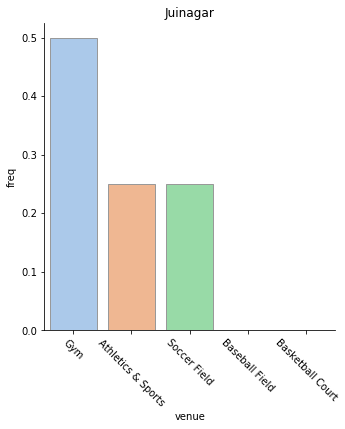

<Figure size 720x504 with 0 Axes>

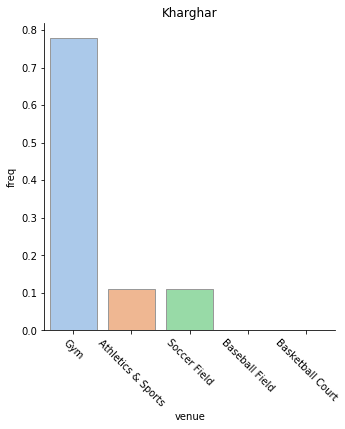

<Figure size 720x504 with 0 Axes>

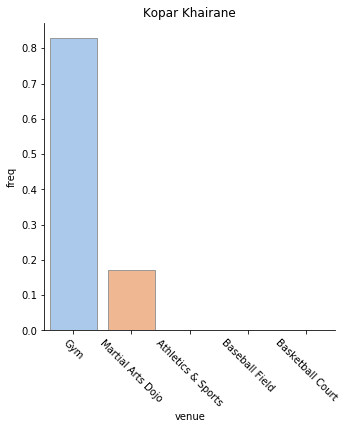

<Figure size 720x504 with 0 Axes>

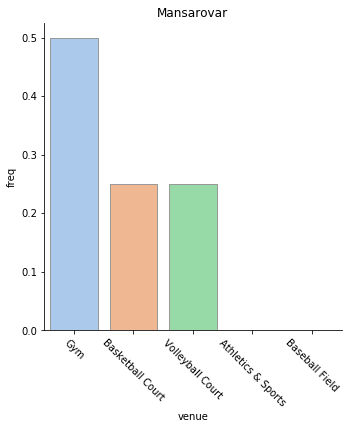

<Figure size 720x504 with 0 Axes>

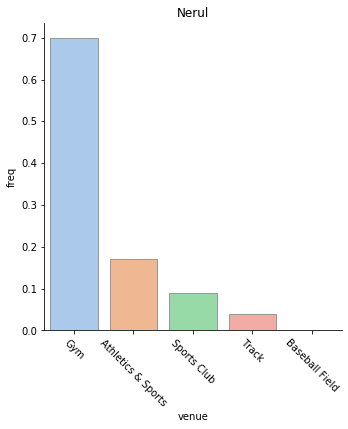

<Figure size 720x504 with 0 Axes>

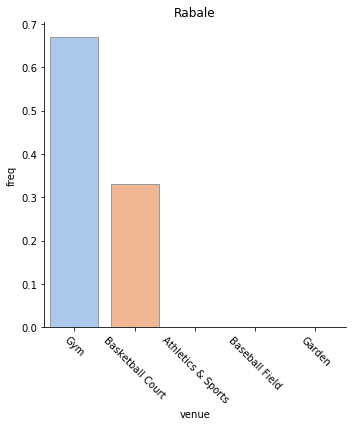

<Figure size 720x504 with 0 Axes>

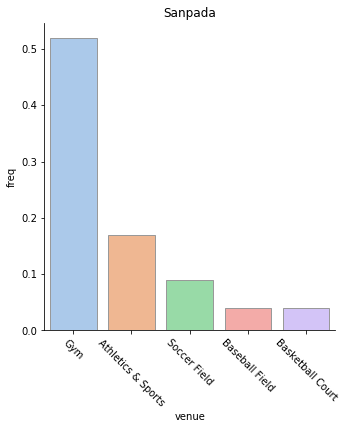

<Figure size 720x504 with 0 Axes>

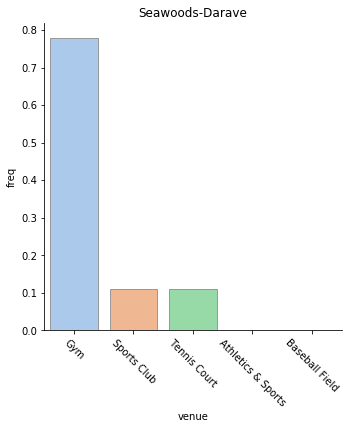

<Figure size 720x504 with 0 Axes>

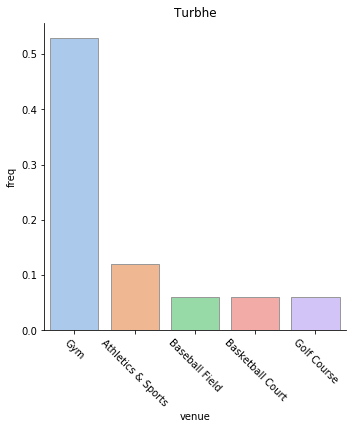

<Figure size 720x504 with 0 Axes>

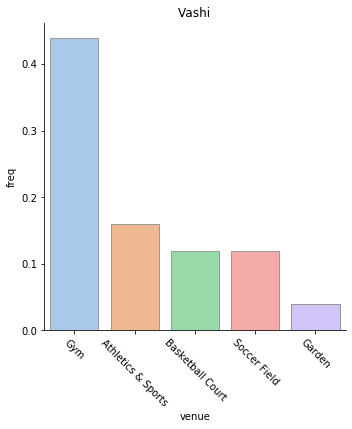

In [26]:
num_top_venues = 5

for hood in nmum_grouped['Neighborhood']:
    temp = nmum_grouped[nmum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    plt.figure(figsize=(10,7))
    sns.catplot(y="freq", x="venue", kind="bar",
            palette="pastel", edgecolor=".6",
            data=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    plt.xticks(rotation=-45)
    plt.title(hood)

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nmum_grouped['Neighborhood']

for ind in np.arange(nmum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nmum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airoli,Gym,Sports Club,Athletics & Sports,Yoga Studio,Volleyball Court,Track,Tennis Court,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)
1,CBD Belapur,Gym,Athletics & Sports,Sporting Goods Shop,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Soccer Field,Residential Building (Apartment / Condo)
2,Ghansoli,Gym,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo),Martial Arts Dojo
3,Juinagar,Gym,Soccer Field,Athletics & Sports,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Residential Building (Apartment / Condo)
4,Kharghar,Gym,Soccer Field,Athletics & Sports,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Residential Building (Apartment / Condo)


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 4 clusters.

In [29]:
# set number of clusters
kclusters = 4

nmum_grouped_clustering = nmum_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nmum_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 1, 2, 2, 3, 0, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nmum_merged = neighborhoods

# merge nmum_grouped with neighborhoods to add latitude/longitude for each neighborhood
nmum_merged = nmum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nmum_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airoli,19.158272,72.996709,0,Gym,Sports Club,Athletics & Sports,Yoga Studio,Volleyball Court,Track,Tennis Court,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)
1,Rabale,19.136637,73.002781,3,Gym,Basketball Court,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)
2,Ghansoli,19.119331,72.999510,2,Gym,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo),Martial Arts Dojo
3,Kopar Khairane,19.102852,73.003075,2,Gym,Martial Arts Dojo,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)
4,Turbhe,19.076165,73.017662,1,Gym,Athletics & Sports,Soccer Field,Residential Building (Apartment / Condo),Hotel,Golf Course,Basketball Court,Baseball Field,Yoga Studio,Volleyball Court


Finally, let's visualize the resulting clusters

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nmum_merged['Latitude'], nmum_merged['Longitude'], nmum_merged['Neighborhood'], nmum_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

#### Cluster 1 (Red)

In [32]:
cluster1 = nmum_merged.loc[nmum_merged['Cluster Labels'] == 0, nmum_merged.columns[[0] + list(range(4, nmum_merged.shape[1]))]]
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airoli,Gym,Sports Club,Athletics & Sports,Yoga Studio,Volleyball Court,Track,Tennis Court,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)
8,Nerul,Gym,Athletics & Sports,Sports Club,Track,Yoga Studio,Volleyball Court,Tennis Court,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)
10,CBD Belapur,Gym,Athletics & Sports,Sporting Goods Shop,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Soccer Field,Residential Building (Apartment / Condo)


#### Cluster 2 (Purple)

In [33]:
cluster2 = nmum_merged.loc[nmum_merged['Cluster Labels'] == 1, nmum_merged.columns[[0] + list(range(4, nmum_merged.shape[1]))]]
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Turbhe,Gym,Athletics & Sports,Soccer Field,Residential Building (Apartment / Condo),Hotel,Golf Course,Basketball Court,Baseball Field,Yoga Studio,Volleyball Court
5,Sanpada,Gym,Athletics & Sports,Soccer Field,Residential Building (Apartment / Condo),Hotel,Golf Course,Basketball Court,Baseball Field,Yoga Studio,Volleyball Court
6,Vashi,Gym,Athletics & Sports,Soccer Field,Basketball Court,Yoga Studio,Sports Club,Golf Course,Garden,Volleyball Court,Track
7,Juinagar,Gym,Soccer Field,Athletics & Sports,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Residential Building (Apartment / Condo)


#### Cluster 3 (Cyan)

In [34]:
cluster3 = nmum_merged.loc[nmum_merged['Cluster Labels'] == 2, nmum_merged.columns[[0] + list(range(4, nmum_merged.shape[1]))]]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Ghansoli,Gym,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo),Martial Arts Dojo
3,Kopar Khairane,Gym,Martial Arts Dojo,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)
9,Seawoods-Darave,Gym,Tennis Court,Sports Club,Yoga Studio,Volleyball Court,Track,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo),Martial Arts Dojo
11,Kharghar,Gym,Soccer Field,Athletics & Sports,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Residential Building (Apartment / Condo)


#### Cluster 4 (Pale Yellow)

In [35]:
cluster4 = nmum_merged.loc[nmum_merged['Cluster Labels'] == 3, nmum_merged.columns[[0] + list(range(4, nmum_merged.shape[1]))]]
cluster4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Rabale,Gym,Basketball Court,Yoga Studio,Volleyball Court,Track,Tennis Court,Sports Club,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)
12,Mansarovar,Gym,Volleyball Court,Basketball Court,Yoga Studio,Track,Tennis Court,Sports Club,Sporting Goods Shop,Soccer Field,Residential Building (Apartment / Condo)


Create a function to plot common venues within each clusters. This will help us find similarity of stations.

In [36]:
def plot_cluster(df):
    plt.figure(figsize=(15,7))
    df_plt = pd.melt(df, var_name="venue")  
    sns.countplot(data=df_plt, x='venue', hue='value')
    plt.xticks(rotation=-45)
    plt.legend(bbox_to_anchor=(1,1), loc=2)

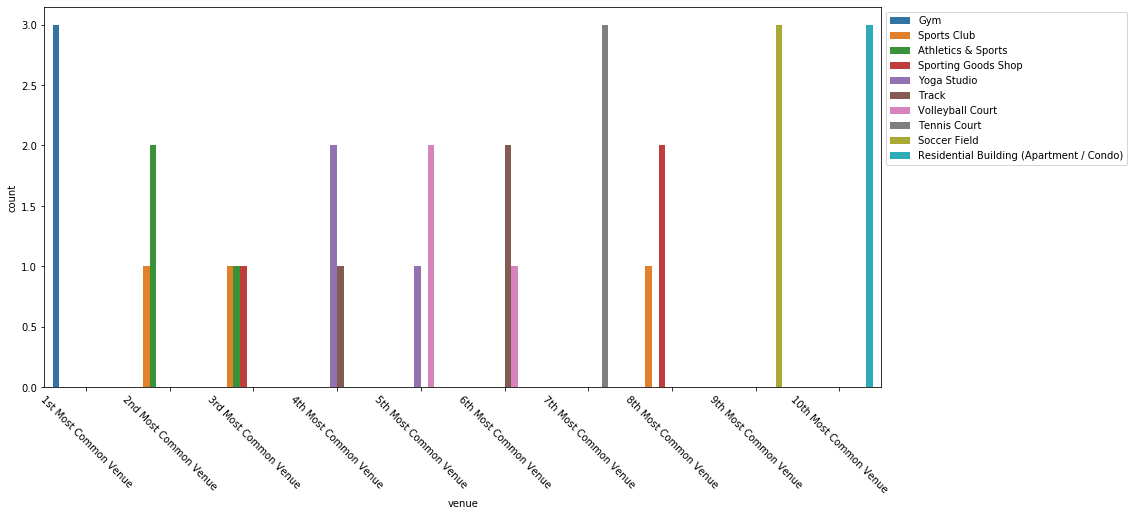

In [37]:
plot_cluster(cluster1.drop(['Neighborhood'],axis=1))

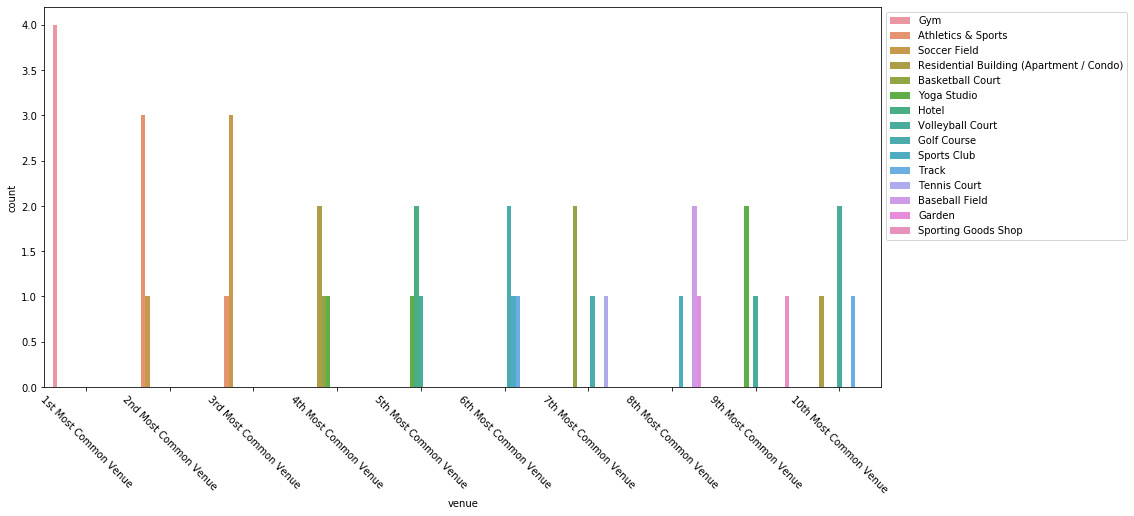

In [38]:
plot_cluster(cluster2.drop(['Neighborhood'],axis=1))

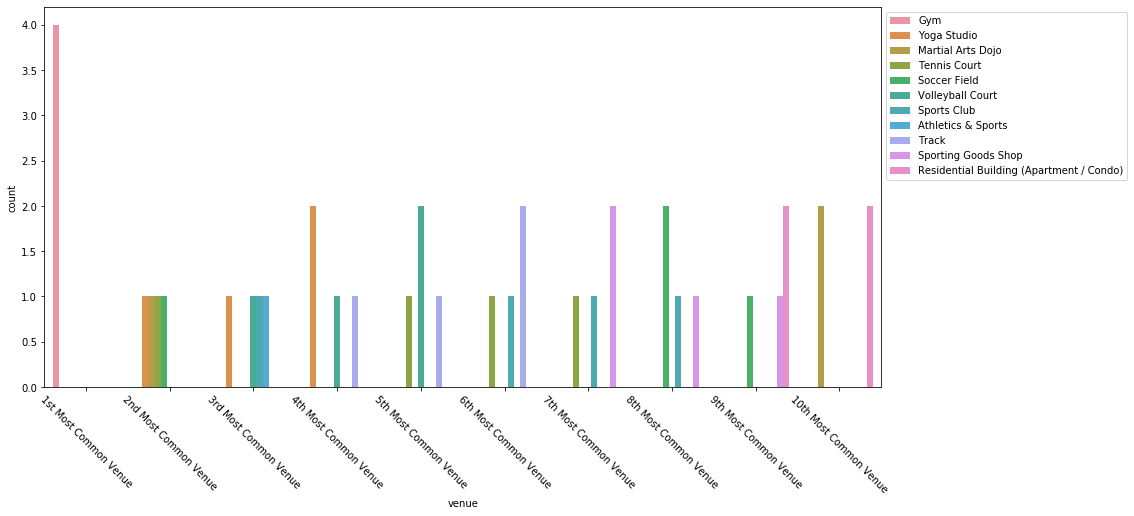

In [39]:
plot_cluster(cluster3.drop(['Neighborhood'],axis=1))

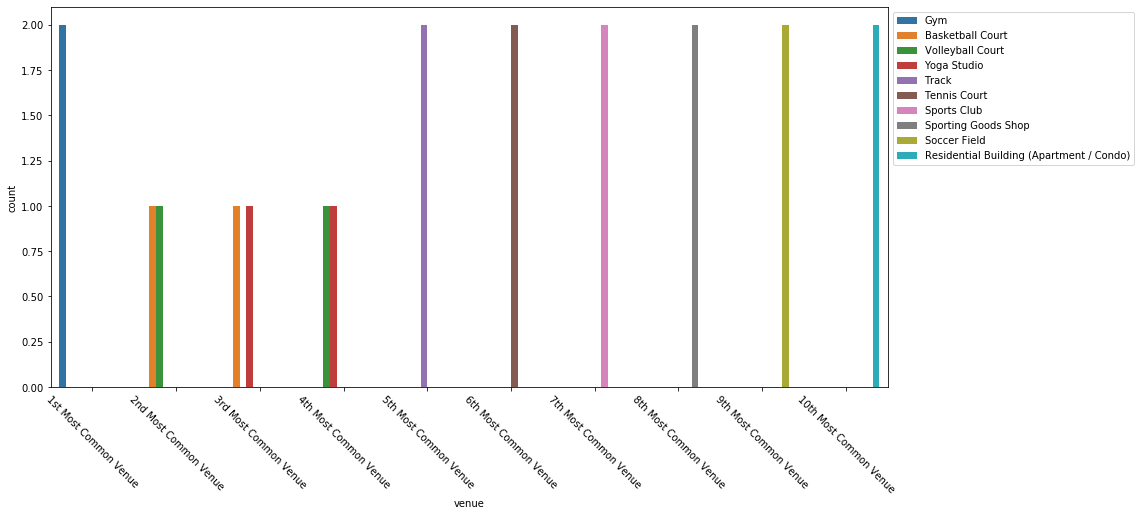

In [40]:
plot_cluster(cluster4.drop(['Neighborhood'],axis=1))

## Conclusion

We are successfully able to group Navi Mumbai stations into 4 different groups based on sports venue.

All the stations are having Gym as their first most common venue. No surprises, it is very common these days.

Below is a detailed analysis of each cluster:
- Cluster 1 (Red) - 3 stations Airoli, Nerul, CBD Belapur; Sports Club
- Cluster 2 (Purple) - 4 stations Turbhe, Sanpada, Vashi, Juinagar; Open field games such as Soccer, Golf, Baseball
- Cluster 3 (Cyan) - 4 stations Ghansoli, Kopar Khairane, Seawoods-Darave,Khargar; Yoga, Martial Arts, Tennis
- Cluster 4 (Pale Yellow) - 2 stations Rabale, Mansarovar; Games played on courts such as Basketball, Volleyball

Now, if any person who play sports and visits Navi Mumbai, looking at this map he can decide which place to go depending which sport he wants to play.